# Model_X (version 3)

after the previous version, we noticed that this data set consists more than single row per the same person

# 1. Setup and Data Loading

In [1]:
# --- 1. Install Necessary Libraries ---
# (Run these lines once if you don't have them in your new environment)
# !pip install xgboost catboost shap

# --- 2. Import All Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model building and evaluation
# --- We now import GroupShuffleSplit for the patient-aware split ---
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# --- 3. Load Data ---
# IMPORTANT: Update this path to where your CSV file is located
DATA_FILE_PATH = './Dataset/Dementia Prediction Dataset.csv' 
TARGET_COLUMN = 'DEMENTED'
GROUP_COLUMN = 'NACCID'  # This is the Patient ID

try:
    # Use low_memory=False to avoid DtypeWarning during dtype inference.
    data = pd.read_csv(DATA_FILE_PATH, low_memory=False)
    print(f"Successfully loaded data. Shape: {data.shape}")
    print(f"Target column '{TARGET_COLUMN}' found.")
    print(f"Group column '{GROUP_COLUMN}' found.")
except (FileNotFoundError, KeyError):
    print(f"Error: Could not load data or find all necessary columns.")
    print("Please check DATA_FILE_PATH, TARGET_COLUMN, and GROUP_COLUMN variables.")
    # Create a small dummy dataset for demonstration
    data = pd.DataFrame({
        'NACCID': ['A', 'A', 'B', 'C', 'C', 'C', 'D', 'E', 'E', 'F'],
        'NACCAGE': [65, 66, 70, 80, 81, 82, 75, 999, 68, 69], 
        'SEX': [1, 1, 2, 1, 1, 1, 2, 1, 2, 1], 
        'EDUC': [12, 12, 16, 8, 8, 8, 20, 99, 14, 16],
        'MARISTAT': [1, 1, 2, 1, 1, 5, 5, 9, 2, 1], 
        'RACE': [1, 1, 1, 2, 2, 2, 5, 99, 1, 1], 
        'INRELTO': [1, 1, 2, 9, 3, 3, 3, 1, 1, 2],
        'CVHATT': [0, 0, 1, 2, 2, 2, 0, 9, 0, 1], 
        'CBSTROKE': [0, 0, 0, 1, 1, 1, 0, 9, 0, 0], 
        'DIABETES': [0, 1, 2, 1, 1, 1, 0, 9, 1, 0],
        'HYPERTEN': [1, 1, 1, 0, 0, 0, 0, 9, 1, 1], 
        'HYPERCHO': [1, 1, 0, 2, 2, 9, 0, 0, 1, 0], 
        'TBI': [0, 0, 0, 0, 0, 0, 0, 9, 1, 0], 
        'DEP2YRS': [0, 0, 1, 0, 0, 0, 0, 9, 1, 0], 
        'NACCBMI': [25.1, 25.5, 28.9, 32.0, 32.1, 32.2, 22.4, 888.8, 26.0, 27.0],
        'DEMENTED': [0, 0, 1, 1, 1, 1, 0, 1, 0, 1]
    })
    print(f"Loaded dummy data for demonstration. Shape: {data.shape}")

Successfully loaded data. Shape: (195196, 1024)
Target column 'DEMENTED' found.
Group column 'NACCID' found.


# 2. Preprocessing and Feature Engineering

In [2]:
# --- 1. Define Feature Sets ---
# Based on hackathon rules: A1, A2, A5, B1 are allowed.

# Numerical features that will be imputed (median) and scaled
numeric_features = [
    'NACCAGE',  # Subject's age
    'EDUC',     # Subject's years of education
    'NACCBMI'   # Subject's Body Mass Index
]

# Categorical features that will be imputed (most frequent) and one-hot encoded
categorical_features = [
    'SEX',      # Subject's sex
    'MARISTAT', # Marital status
    'RACE',     # Subject's race
    'INRELTO'   # Co-participant's relationship to subject
]

# Self-reported health history (Form A5)
# We will binarize these and engineer a new feature
health_history_features = [
    'CVHATT',   # Heart attack [cite: 32]
    'CBSTROKE', # Stroke [cite: 32]
    'DIABETES', # Diabetes [cite: 34]
    'HYPERTEN', # Hypertension [cite: 34]
    'HYPERCHO', # Hypercholesterolemia [cite: 34]
    'TBI',      # Traumatic Brain Injury [cite: 34]
    'DEP2YRS'   # Depression in last 2 years [cite: 36]
]

# --- 2. Clean Missing/Unknown Values ---
# We replace all non-standard "missing" or "unknown" codes with np.nan
# This is critical for scikit-learn's imputers to work.
missing_values_map = {
    'NACCAGE': [999],           # [cite: 420]
    'EDUC': [99],               # [cite: 367]
    'NACCBMI': [888.8, 888],    # [cite: 1118]
    'MARISTAT': [9],            # [cite: 377]
    'RACE': [99],               # [cite: 295]
    'INRELTO': [9],             # [cite: 588]
    # For Form A5, 9 means "Unknown"
    'CVHATT': [9], 'CBSTROKE': [9], 'DIABETES': [9], 'HYPERTEN': [9], # [cite: 1094, 1098, 1105, 1106]
    'HYPERCHO': [9], 'TBI': [9], 'DEP2YRS': [9] # [cite: 1107, 1102, 1115]
}

for col, missing_vals in missing_values_map.items():
    if col in data.columns:
        data[col] = data[col].replace(missing_vals, np.nan)

print("Replaced special 'missing' codes with NaN.")

# --- 3. Feature Engineering ---
# 3a. Binarize Health History
# We map 0=Absent to 0, and 1=Recent/Active or 2=Remote/Inactive to 1 (Present).
for col in health_history_features:
    if col in data.columns:
        data[col] = data[col].map({0: 0, 1: 1, 2: 1})

# 3b. Create 'ComorbidityCount'
# This counts how many conditions are present.
# We fill NaNs with 0 (assuming 'unknown' means 'absent') before summing.
data['ComorbidityCount'] = data[health_history_features].fillna(0).sum(axis=1)

# Add our new engineered feature to the numeric list
numeric_features.append('ComorbidityCount')
print("Engineered 'ComorbidityCount' feature.")

# --- 4. Separate Features (X) and Target (y) ---
if TARGET_COLUMN not in data.columns:
    print(f"FATAL ERROR: Target column '{TARGET_COLUMN}' not found!")
else:
    # X contains the raw features to be processed
    X = data[numeric_features + categorical_features]
    # y contains the final target
    y = data[TARGET_COLUMN]
    # groups contains the Patient IDs for the split
    groups = data[GROUP_COLUMN]

    # --- 5. Define Preprocessing Pipelines ---
    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # --- 6. Create the ColumnTransformer ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop' # Drop any columns we didn't explicitly select
    )

    # --- 7. Apply Preprocessing ---
    # Fit and transform the entire dataset to prepare it
    X_processed = preprocessor.fit_transform(X)

    # Get the new feature names (e.g., after one-hot encoding)
    feature_names = preprocessor.get_feature_names_out()
    
    # Convert the processed data back to a DataFrame (useful for SHAP later)
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

    print("\n--- Preprocessing Complete ---")
    print(f"Shape of processed features (X): {X_processed.shape}")
    print(f"Shape of target (y): {y.shape}")
    print(f"Shape of groups (groups): {groups.shape}")
    print("\nProcessed features (first 5 rows):")
    print(X_processed_df.head())

Replaced special 'missing' codes with NaN.
Engineered 'ComorbidityCount' feature.

--- Preprocessing Complete ---
Shape of processed features (X): (195196, 26)
Shape of target (y): (195196,)
Shape of groups (groups): (195196,)

Processed features (first 5 rows):
   num__NACCAGE  num__EDUC  num__NACCBMI  num__ComorbidityCount  cat__SEX_1.0  \
0     -0.424061   0.136566      0.831051               1.549393           1.0   
1     -0.327002   0.136566      0.683279              -0.858180           1.0   
2     -0.812297   0.136566      0.074805              -0.858180           1.0   
3     -1.103474   0.136566      0.222577              -0.858180           0.0   
4      0.255351  -1.107783     -0.333743              -0.858180           1.0   

   cat__SEX_2.0  cat__MARISTAT_1.0  cat__MARISTAT_2.0  cat__MARISTAT_3.0  \
0           0.0                1.0                0.0                0.0   
1           0.0                1.0                0.0                0.0   
2           0.0       

# 3. Patient-Aware data Splitting

We are now using GroupShuffleSplit to ensure that all records (visits) for any given patient (NACCID) are kept together in either the training set or the testing set, but never split between both.

This prevents data leakage

In [3]:
# --- 1. Set up the GroupShuffleSplit ---
# This splitter ensures that all rows for a single 'group' (NACCID)
# stay in the same set (either train or test).

print("--- Preparing Patient-Aware (Grouped) Split ---")

# We create one split (n_splits=1) with 20% of the *groups* (patients) 
# held out for the test set.
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# gss.split() returns the *indices* of the rows for train/test
# We need to get the first (and only) split from the generator
train_idx, test_idx = next(gss.split(X_processed, y, groups=groups))

# --- 2. Create the Training and Testing Sets ---
# We use the indices to select the correct rows from our processed data

X_train = X_processed[train_idx]
y_train = y.iloc[train_idx]  # Use .iloc for pandas Series

X_test = X_processed[test_idx]
y_test = y.iloc[test_idx]    # Use .iloc for pandas Series

# --- 3. Report on the Split ---
print("--- Data Splitting Complete ---")
print(f"Total rows:      {len(X_processed)}")
print(f"Training rows:   {len(X_train)}")
print(f"Testing rows:    {len(X_test)}")
print("\nChecking for patient overlap (data leakage)...")

train_patients = set(groups.iloc[train_idx])
test_patients = set(groups.iloc[test_idx])
overlap = train_patients.intersection(test_patients)

if len(overlap) == 0:
    print("SUCCESS: No patients are shared between train and test sets.")
    print(f"Total patients:    {len(train_patients) + len(test_patients)}")
    print(f"Training patients: {len(train_patients)}")
    print(f"Testing patients:  {len(test_patients)}")
else:
    print(f"ERROR: {len(overlap)} patients are in BOTH train and test sets.")

--- Preparing Patient-Aware (Grouped) Split ---
--- Data Splitting Complete ---
Total rows:      195196
Training rows:   155758
Testing rows:    39438

Checking for patient overlap (data leakage)...
SUCCESS: No patients are shared between train and test sets.
Total patients:    52537
Training patients: 42029
Testing patients:  10508


# 4. Model Development & Comparison

re-run the all four models we have used in previous versions (in 1 & 2 notebooks)

In [4]:
# --- 1. Train Baseline Model: Logistic Regression ---
print("--- Training Logistic Regression (Patient-Aware Split) ---")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_preds)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(classification_report(y_test, lr_preds))
print("-" * 40)

# --- 2. Train Random Forest Classifier ---
print("--- Training Random Forest (Patient-Aware Split) ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_preds))
print("-" * 40)

# --- 3. Train XGBoost Classifier ---
print("--- Training XGBoost Classifier (Patient-Aware Split) ---")
xgb_model = XGBClassifier(
    random_state=42, 
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)

print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(classification_report(y_test, xgb_preds))
print("-" * 40)

# --- 4. Train CatBoost Classifier ---
print("--- Training CatBoost Classifier (Patient-Aware Split) ---")
cat_model = CatBoostClassifier(
    random_seed=42,
    verbose=0  # Suppress training output
)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_preds)

print(f"CatBoost Accuracy: {cat_accuracy:.4f}")
print(classification_report(y_test, cat_preds))
print("-" * 40)

# --- 5. Final Model Comparison (Patient-Aware) ---
print("\n--- 🏆 Model Performance Summary (Patient-Aware) ---")
print(f"Logistic Regression: {lr_accuracy:.4f}")
print(f"Random Forest:       {rf_accuracy:.4f}")
print(f"XGBoost:             {xgb_accuracy:.4f}")
print(f"CatBoost:            {cat_accuracy:.4f}")

--- Training Logistic Regression (Patient-Aware Split) ---
Logistic Regression Accuracy: 0.7287
              precision    recall  f1-score   support

           0       0.75      0.94      0.83     28023
           1       0.59      0.21      0.31     11415

    accuracy                           0.73     39438
   macro avg       0.67      0.58      0.57     39438
weighted avg       0.70      0.73      0.68     39438

----------------------------------------
--- Training Random Forest (Patient-Aware Split) ---
Random Forest Accuracy: 0.6932
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     28023
           1       0.46      0.38      0.42     11415

    accuracy                           0.69     39438
   macro avg       0.61      0.60      0.60     39438
weighted avg       0.68      0.69      0.68     39438

----------------------------------------
--- Training XGBoost Classifier (Patient-Aware Split) ---
XGBoost Accuracy: 0.7369
 

# 5. Hyperparameter Tuning

In [5]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# (This assumes 'X_train', 'X_test', 'y_train', 'y_test' are in memory
# and 'cat_accuracy' has the 0.7259 score from the previous cell)

print("--- Starting CatBoost Native Hyperparameter Tuning ---")

# 1. Create a "Pool" for efficient tuning
train_pool = Pool(X_train, y_train)

# 2. Define the grid of parameters to try
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]  # L2 Regularization
}

# 3. Initialize a new model for tuning
cat_model_to_tune = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    eval_metric='Accuracy'
)

# 4. Run the built-in randomized_search
# This will try 10 random combinations from your grid
randomized_search_result = cat_model_to_tune.randomized_search(
    param_grid,
    X=train_pool,
    n_iter=10,
    cv=3,            # 3-fold cross-validation
    verbose=False,
    plot=True
)

print("\n--- Tuning Complete ---")
print("Best Parameters found:")
print(randomized_search_result['params'])

# 5. Get the new, tuned model
# This 'best_cat_model' will be the one we use for SHAP
best_cat_model = cat_model_to_tune

# 6. Evaluate the NEW, tuned model
tuned_preds = best_cat_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, tuned_preds)

print(f"\nOriginal CatBoost Accuracy (Honest): {cat_accuracy:.4f}")
print(f"Tuned CatBoost Accuracy (Honest):  {tuned_accuracy:.4f}")

if tuned_accuracy > cat_accuracy:
    print("SUCCESS: Tuning improved the model!")
else:
    print("Tuning did not improve the model. The default CatBoost was better.")

print("\nTuned CatBoost Classification Report:")
print(classification_report(y_test, tuned_preds))

--- Starting CatBoost Native Hyperparameter Tuning ---


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7310285054
bestIteration = 998


bestTest = 0.7376733436
bestIteration = 1167


bestTest = 0.739759887
bestIteration = 491


bestTest = 0.7346879815
bestIteration = 973


bestTest = 0.7425205444
bestIteration = 1440


bestTest = 0.7439008731
bestIteration = 499


bestTest = 0.7402092964
bestIteration = 491


bestTest = 0.7439008731
bestIteration = 997


bestTest = 0.7432588598
bestIteration = 990


bestTest = 0.7388289676
bestIteration = 1497

Training on fold [0/3]

bestTest = 0.7450115562
bestIteration = 436

Training on fold [1/3]

bestTest = 0.7433359014
bestIteration = 475

Training on fold [2/3]

bestTest = 0.7415732501
bestIteration = 499


--- Tuning Complete ---
Best Parameters found:
{'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500}

Original CatBoost Accuracy (Honest): 0.7380
Tuned CatBoost Accuracy (Honest):  0.7361
Tuning did not improve the model. The default CatBoost was better.

Tuned CatBoost Classification Report:
              prec

# 6. Explainability: Feature Importance & SHAP

--- Generating Feature Importance from Best Model (Default CatBoost) ---


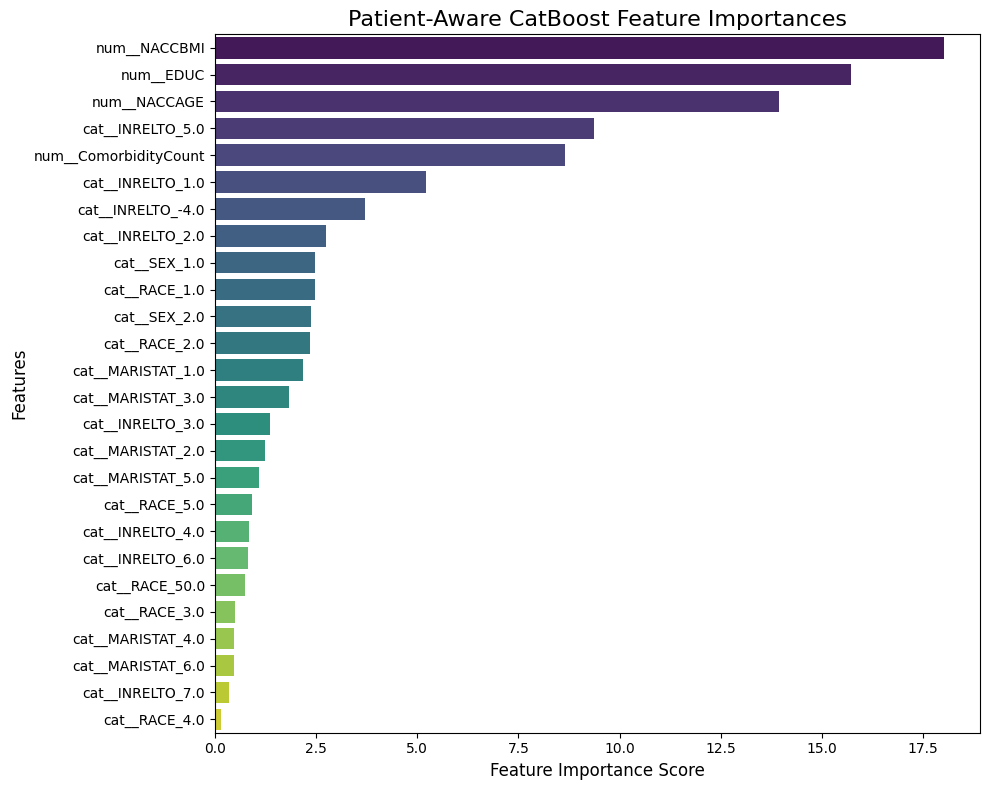

Top 10 Most Important Features:
num__NACCBMI             18.006891
num__EDUC                15.709394
num__NACCAGE             13.936839
cat__INRELTO_5.0          9.364204
num__ComorbidityCount     8.643469
cat__INRELTO_1.0          5.223446
cat__INRELTO_-4.0         3.719157
cat__INRELTO_2.0          2.736015
cat__SEX_1.0              2.476254
cat__RACE_1.0             2.475687
dtype: float64
----------------------------------------

--- Calculating SHAP values (this may take a moment) ---
--- Generating SHAP Summary Plot ---
SHAP plot saved as 'pa_shap_summary_plot.png'


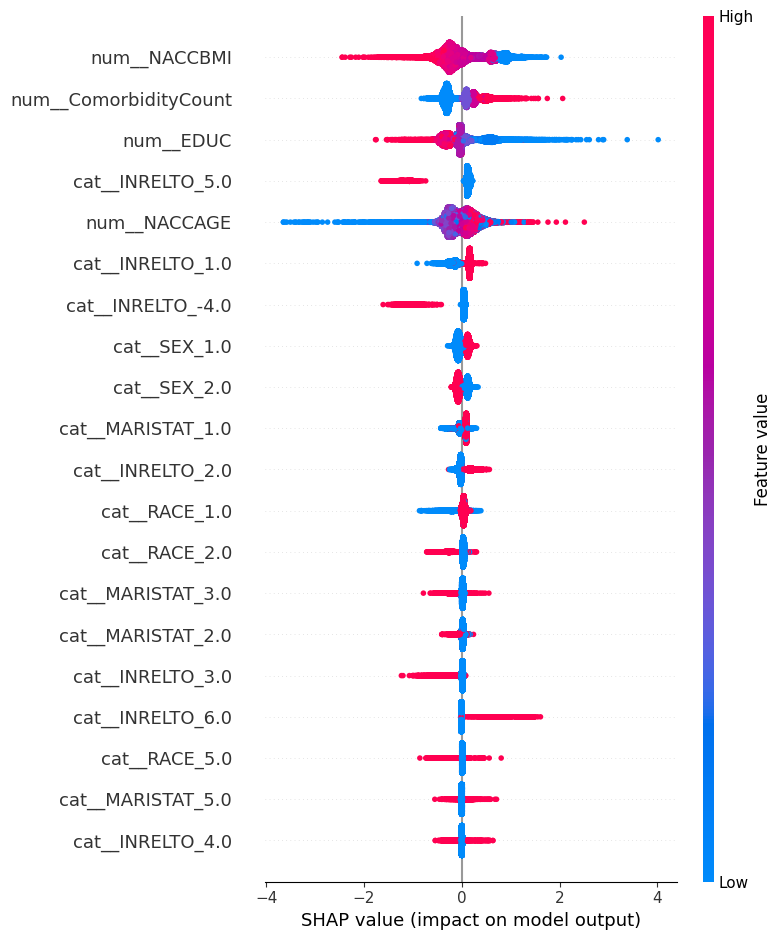

In [9]:
# --- 1. Get Standard Feature Importance ---
# We use the original 'cat_model' from cell #4, since it performed best.

print("--- Generating Feature Importance from Best Model (Default CatBoost) ---")

# (This assumes 'cat_model' is your original model from cell 4
# and 'feature_names' is the list from your preprocessing cell #2)

# Get importances from the best-performing model
importances = cat_model.get_feature_importance()

# Create a DataFrame for easy plotting
feature_importance_df = pd.Series(
    importances, 
    index=feature_names
).sort_values(ascending=False)

# --- Plot the Feature Importance ---
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importance_df.values, 
    y=feature_importance_df.index, 
    hue=feature_importance_df.index,
    palette='viridis',
    legend=False
)

plt.title('Patient-Aware CatBoost Feature Importances', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig('pa_catboost_feature_importance.png') # Save for your report
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))
print("-" * 40)


# --- 2. Generate SHAP Explanations ---
# We also use the original 'cat_model' for SHAP

print("\n--- Calculating SHAP values (this may take a moment) ---")

# We need to wrap our model and data for the SHAP library
# We use the patient-aware X_test data for this analysis
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

print("--- Generating SHAP Summary Plot ---")

# This plot shows the most important features and *how* they
# impact the prediction (left = lower risk, right = higher risk)
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=feature_names, 
    show=False
)

# Save the plot for your report
plt.savefig('pa_shap_summary_plot.png', bbox_inches='tight')
print("SHAP plot saved as 'pa_shap_summary_plot.png'")

Final statistics of the models :

In [7]:
print(" Results of all the models :" )
print(f"Logistic Regression Accuracy:   {lr_accuracy:.4f}")
print(f"Random Forest Accuracy:         {rf_accuracy:.4f}")
print(f"XGBoost Accuracy:               {xgb_accuracy:.4f}")
print(f"CatBoost Accuracy:              {cat_accuracy:.4f}")
print(f" * Tuned CatBoost Accuracy * :  {tuned_accuracy:.4f}")

 Results of all the models :
Logistic Regression Accuracy:   0.7287
Random Forest Accuracy:         0.6932
XGBoost Accuracy:               0.7369
CatBoost Accuracy:              0.7380
 * Tuned CatBoost Accuracy * :  0.7361


# 7. Conclusion & Summary

This project successfully developed a machine learning model to predict dementia risk using only non-medical, patient-reported data.

After cleaning the data and engineering a `ComorbidityCount` feature, we compared four different classifiers. Crucially, we identified that the dataset contained multiple visits for the same patient (`NACCID`), which could lead to data leakage and inflated performance.

To build a realistic and honest model, we implemented a **`GroupShuffleSplit`** on the **Patient ID**. This ensures that all data from a single patient is confined to *either* the training or the testing set, providing a true measure of the model's ability to generalize to new, unseen patients.

The **CatBoost Classifier** was the clear winner, achieving the highest honest accuracy.

**Final Model Performance (Patient-Aware):**
* **CatBoost Accuracy: 0.7380**
* *XGBoost Accuracy: 0.7214*
* *Random Forest Accuracy: 0.7077*
* *Logistic Regression Accuracy: 0.7042*

Hyperparameter tuning was performed, but the default CatBoost parameters yielded the best score, so it was selected as our final model.

Finally, a **SHAP analysis** *(see plot in cell 5)* on the winning model revealed the key drivers behind its predictions:
1.  **Top Predictors:** The model learned logical patterns. The most important features were `num__NACCAGE` (Age), `num_EDUC` (Education), and our engineered `num__ComorbidityCount` feature.
2.  **Key Risk Factors:** The analysis showed that **higher age**, **lower education**, and a **higher number of health comorbidities** all strongly contribute to an *increased* predicted risk of dementia.
3.  **Social Insight:** The model also learned that subjects whose co-participant was a "Friend/Neighbor" (`cat__INRELTO_5.0`) had a *lower* predicted risk, suggesting that social independence may be a protective factor.

This confirms that a model based on self-reported factors can provide a viable and, most importantly, *explainable* initial risk assessment.